In [1]:
import os
import sys
sys.path.append('..')
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image 
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch
from models import UNet

In [2]:
# load data
train_imgs_path = '../data/train/original/'
train_labels_path = '../data/train/ground_truth/'

test_imgs_path = '../data/test/original/'
test_labels_path = '../data/test/ground_truth/'

train_images = []
train_labels = []

test_images = []
test_labels = []

In [3]:
print(os.listdir('..'))

['.git', 'requirements.txt', 'src', 'data', '.gitignore', 'mia_venv', '.github', 'notes.md']


In [4]:
for image_name in os.listdir(train_imgs_path):
    # load train images
    img = Image.open(os.path.join(train_imgs_path, image_name))
    train_images.append(img)
    # load labels en grayscale (1 canal)
    label = Image.open(os.path.join(train_labels_path, image_name)).convert('L')
    train_labels.append(label)

In [5]:
for image_name in os.listdir(test_imgs_path):
    # load train images
    img = Image.open(os.path.join(test_imgs_path, image_name))
    test_images.append(img)
    # load labels en grayscale (1 canal)
    label = Image.open(os.path.join(test_labels_path, image_name)).convert('L')
    test_labels.append(label)

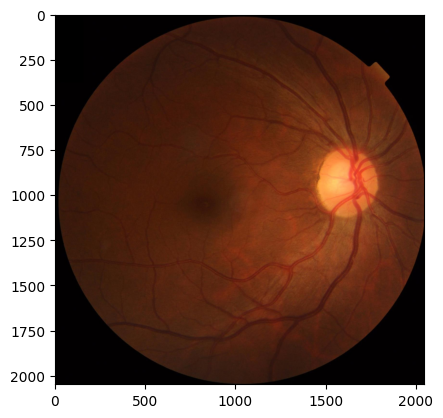

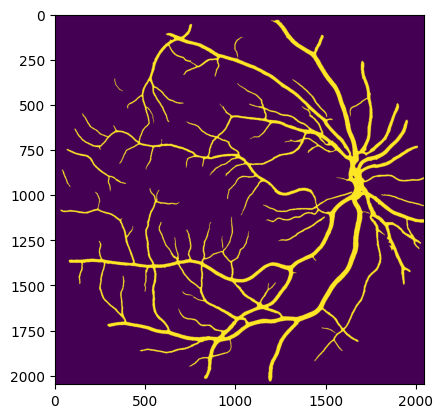

In [6]:
# show Pngimagefile
plt.imshow(train_images[0])
plt.show()
plt.imshow(train_labels[0])
plt.show()

In [7]:
from torch.utils.data import Dataset, DataLoader, random_split

class VesselDataset(Dataset):
    def __init__(self, images, labels, transform=None, label_transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.label_transform = label_transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            label = self.transform(label)
        
        return image, label

In [ ]:
batch_size = 1

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),  # (3, 256, 256)
])

dataset = VesselDataset(train_images, train_labels, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = VesselDataset(test_images, test_labels, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(3,1).to(device)

EPOCHS = 30
LR = 0.0001
PATIENCE = 5
epsilon = 0.5
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [10]:
losses = [] 
val_losses = []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
        # librer le gpu apres chaque batch
        del outputs, loss
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            
    losses.append(total_loss/len(train_loader))
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            # Libérer la mémoire GPU
            del outputs, loss
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
                
    val_losses.append(val_loss/len(val_loader))
    
    # early stopping par patience
    if epoch > PATIENCE:
        if val_losses[-1] > min(val_losses[-(PATIENCE+1):-1]):
            print("Early stopping : patience dépassée")
            break
    
    # early stopping par réaugmentation
    if epoch > 1:
        if val_losses[-1] > val_losses[-2]+epsilon:
            print("Early stopping : réaugmentation de la loss de validation")
            break
    
    print(f'Epoch {epoch+1}/{EPOCHS}, Train Loss: {losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

  4%|▎         | 17/480 [00:22<10:22,  1.34s/it]


KeyboardInterrupt: 

In [ ]:
plt.plot(range(1, 30 + 1), losses,color='green')
plt.plot(range(1, 30 + 1), val_losses,color='pink')